Implimenting bayesian hierarchical modeling on beta arrestin parameter (Kba)

# Imports & setup

The code is based off an example in this cite: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html#adding-group-level-predictors

In [2]:
# Imports & set up
import warnings

import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr
import seaborn as sns
import os
import copy

from scipy.special import expit as logistic
import pytensor.tensor as at

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.11.0


In [3]:
# Initialize random number generator
RANDOM_SEED = 8927
az.style.use("arviz-darkgrid")

In [4]:
# Set the working directory 

# Define the base directory
base_dir = 'Set the base directory here'

# Change the working directory 
print(os.getcwd()) # Prints the current working directory

# Provide the new path here
new_dir = os.path.join(base_dir, 'data')
if os.path.exists(new_dir):
    os.chdir(new_dir)
else:
    print(f"Directory {new_dir} does not exist.")

# Prints the new working directory
print(os.getcwd()) 

# Define the results directories
results_directory_figures = os.path.join(base_dir, 'results/figures/python')
results_directory_tables = os.path.join(base_dir, 'results/tables')

# Check if the directories exist
if not os.path.exists(results_directory_figures):
    print(f"Directory {results_directory_figures} does not exist.")
if not os.path.exists(results_directory_tables):
    print(f"Directory {results_directory_tables} does not exist.")

/Users/preetidubey/Library/CloudStorage/OneDrive-SharedLibraries-UW/Cheri Fang - Imoukhuede_Lab_UW/3. Paper Preparation/Preeti Dubey/Dubey et al (2023)/Simulation_code/Final_files_publication/py_scripts
Directory Set the base directory here/data does not exist.
/Users/preetidubey/Library/CloudStorage/OneDrive-SharedLibraries-UW/Cheri Fang - Imoukhuede_Lab_UW/3. Paper Preparation/Preeti Dubey/Dubey et al (2023)/Simulation_code/Final_files_publication/py_scripts
Directory Set the base directory here/results/figures/python does not exist.
Directory Set the base directory here/results/tables does not exist.


# Data Set up

In [5]:
# Import data
oxtr_data = pd.read_excel("OXT_All_Parameters_01122024.xlsx")
oxtr_data.columns = oxtr_data.columns.map(str.strip)
oxtr_data_kd = oxtr_data[oxtr_data.Symbol == "Kon, Koff"].copy()
display(oxtr_data_kd)

Symbol                  Parameter                    Reference  \
0   Kon, Koff  OXT:OXTR Binding Affinity              Den et al. 1981   
1   Kon, Koff  OXT:OXTR Binding Affinity          Rivera et al. 1990    
2   Kon, Koff  OXT:OXTR Binding Affinity        Rezapour et al. 1996    
3   Kon, Koff  OXT:OXTR Binding Affinity         Phaneuf et al. 1997    
4   Kon, Koff  OXT:OXTR Binding Affinity            Fuchs et al. 1984   
5   Kon, Koff  OXT:OXTR Binding Affinity              Den et al. 1981   
6   Kon, Koff  OXT:OXTR Binding Affinity              Den et al. 1981   
7   Kon, Koff  OXT:OXTR Binding Affinity     A. R. Fuchs et al. 1985    
8   Kon, Koff  OXT:OXTR Binding Affinity               Gulliver 2020    
9   Kon, Koff  OXT:OXTR Binding Affinity  Y. Waltenspühl et al. 2022    
10  Kon, Koff  OXT:OXTR Binding Affinity           Kojro et al. 1991    
11  Kon, Koff  OXT:OXTR Binding Affinity         U. Klein et al 1995    
12  Kon, Koff  OXT:OXTR Binding Affinity   F. Fahrenholz et al. 1988    
13  Kon, Koff  OXT:OXTR Binding Affinity       V. Pliska et al. 1986    
14  Kon, Koff  OXT:OXTR Binding Affinity       V. Pliska et al. 1986    
15  Kon, Koff  OXT:OXTR Binding Affinity           Anouar et al. 1996   
16  Kon, Koff  OXT:OXTR Binding Affinity       V. Pliska et al. 1986    

   Binding Partner            Receptor                  Method  \
0         Oxytocin  Oxytocin receptor      Radioligand Binding   
1         Oxytocin  Oxytocin receptor      Radioligand Binding   
2         Oxytocin   Oxytocin receptor     Radioligand Binding   
3         Oxytocin  Oxytocin receptor      Radioligand Binding   
4         Oxytocin  Oxytocin receptor      Radioligand Binding   
5         Oxytocin  Oxytocin receptor      Radioligand Binding   
6         Oxytocin  Oxytocin receptor      Radioligand Binding   
7         Oxytocin  Oxytocin receptor      Radioligand Binding   
8         Oxytocin  Oxytocin receptor      Radioligand Binding   
9         Oxytocin  Oxytocin receptor                     FRET   
10        Oxytocin  Oxytocin receptor      Radioligand Binding   
11        Oxytocin  Oxytocin receptor   Photoaffinity labeling   
12        Oxytocin  Oxytocin receptor   Photoaffinity labeling   
13        Oxytocin  Oxytocin receptor         Binding Isotherm   
14        Oxytocin  Oxytocin receptor         Binding Isotherm   
15        Oxytocin  Oxytocin receptor      Radioligand Binding   
16        Oxytocin  Oxytocin receptor         Binding Isotherm   

              Ligand/Receptor Source association rate dissociation rate  \
0            Myometrial (Term Human)              NaN               NaN   
1            Myometrial (Term Human)                -                 -   
2            Myometrial (Term Human)                -                 -   
3            Myometrial (Term Human)                -                 -   
4            Myometrial (Term Human)              NaN               NaN   
5   Myometrial (1st trimester Human)              NaN               NaN   
6     Myometrial (Nonpregnant Human)              NaN               NaN   
7     Myometrial (Nonpregnant Human)                -                 -   
8                 Transfected HEK293                -                 -   
9                 Transfected HEK293                -                 -   
10           Myometrial (Guinea Pig)                -                 -   
11           Myometrial (Guinea Pig)                -                 -   
12           Myometrial (Guinea Pig)                -                 -   
13               Myometrial (Cattle)                -                 -   
14                Myometrial (Sheep)                -                 -   
15                  Myometrial (Rat)              NaN               NaN   
16                  Myometrial (Rat)                -                 -   

             Kd Note  
0    1.87 ± 0.3  NaN  
1   0.93 ± 0.29  NaN  
2    1.2 ± 0.21  NaN  
3    1.6 ± 0.00  NaN  
4    1.7 ± 0.46  NaN  
5   2.71 ± 1.0

In [6]:
# Clean the dataframe
oxtr_data_kd = oxtr_data_kd.drop(['association rate', 'dissociation rate', 'Note'], axis=1) # remove two unnecessary columns
oxtr_data_kd = oxtr_data_kd.rename(columns={'Ligand/Receptor Source': 'Source'}) # Rename Ligand/Receptor Source to 'Source'
display(oxtr_data_kd)
# Extract Data for the Outcome variable 
kd_data = pd.DataFrame(oxtr_data_kd['Kd'])
kd_data['Kd'] = kd_data['Kd'].str.split(n=1).str[0] # Split the data in the column Kd
kd_data = kd_data.astype({'Kd': 'float64'}) # Change the data type of the Kd column to float
kd_mean_binding_affinity = kd_data["Kd"].mean()
display(kd_data)

Symbol                  Parameter                    Reference  \
0   Kon, Koff  OXT:OXTR Binding Affinity              Den et al. 1981   
1   Kon, Koff  OXT:OXTR Binding Affinity          Rivera et al. 1990    
2   Kon, Koff  OXT:OXTR Binding Affinity        Rezapour et al. 1996    
3   Kon, Koff  OXT:OXTR Binding Affinity         Phaneuf et al. 1997    
4   Kon, Koff  OXT:OXTR Binding Affinity            Fuchs et al. 1984   
5   Kon, Koff  OXT:OXTR Binding Affinity              Den et al. 1981   
6   Kon, Koff  OXT:OXTR Binding Affinity              Den et al. 1981   
7   Kon, Koff  OXT:OXTR Binding Affinity     A. R. Fuchs et al. 1985    
8   Kon, Koff  OXT:OXTR Binding Affinity               Gulliver 2020    
9   Kon, Koff  OXT:OXTR Binding Affinity  Y. Waltenspühl et al. 2022    
10  Kon, Koff  OXT:OXTR Binding Affinity           Kojro et al. 1991    
11  Kon, Koff  OXT:OXTR Binding Affinity         U. Klein et al 1995    
12  Kon, Koff  OXT:OXTR Binding Affinity   F. Fahrenholz et al. 1988    
13  Kon, Koff  OXT:OXTR Binding Affinity       V. Pliska et al. 1986    
14  Kon, Koff  OXT:OXTR Binding Affinity       V. Pliska et al. 1986    
15  Kon, Koff  OXT:OXTR Binding Affinity           Anouar et al. 1996   
16  Kon, Koff  OXT:OXTR Binding Affinity       V. Pliska et al. 1986    

   Binding Partner            Receptor                  Method  \
0         Oxytocin  Oxytocin receptor      Radioligand Binding   
1         Oxytocin  Oxytocin receptor      Radioligand Binding   
2         Oxytocin   Oxytocin receptor     Radioligand Binding   
3         Oxytocin  Oxytocin receptor      Radioligand Binding   
4         Oxytocin  Oxytocin receptor      Radioligand Binding   
5         Oxytocin  Oxytocin receptor      Radioligand Binding   
6         Oxytocin  Oxytocin receptor      Radioligand Binding   
7         Oxytocin  Oxytocin receptor      Radioligand Binding   
8         Oxytocin  Oxytocin receptor      Radioligand Binding   
9         Oxytocin  Oxytocin receptor                     FRET   
10        Oxytocin  Oxytocin receptor      Radioligand Binding   
11        Oxytocin  Oxytocin receptor   Photoaffinity labeling   
12        Oxytocin  Oxytocin receptor   Photoaffinity labeling   
13        Oxytocin  Oxytocin receptor         Binding Isotherm   
14        Oxytocin  Oxytocin receptor         Binding Isotherm   
15        Oxytocin  Oxytocin receptor      Radioligand Binding   
16        Oxytocin  Oxytocin receptor         Binding Isotherm   

                              Source           Kd  
0            Myometrial (Term Human)   1.87 ± 0.3  
1            Myometrial (Term Human)  0.93 ± 0.29  
2            Myometrial (Term Human)   1.2 ± 0.21  
3            Myometrial (Term Human)   1.6 ± 0.00  
4            Myometrial (Term Human)   1.7 ± 0.46  
5   Myometrial (1st trimester Human)  2.71 ± 1.03  
6     Myometrial (Nonpregnant Human)  3.33 ± 0.50  
7     Myometrial (Nonpregnant Human)  0.96 ± 0.48  
8                 Transfected HEK293  0.56 ± 0.00  
9                 Transfected HEK293   1.4 ± 0.20  
10           Myometrial (Guinea Pig)   2.6 ± 0.10  
11           Myometrial (Guinea Pig)   1.5 ± 0.00  
12           Myometrial (Guinea Pig)    2.6 ± 0.2  
13               Myometrial (Cattle)  2.52 ± 0.00  
14                Myometrial (Sheep)  4.04 ± 0.00  
15                  Myometrial (Rat)  1.21 ± 0.34  
16                  Myometrial (Rat)  9.32 ± 0.00

Kd
0   1.87
1   0.93
2   1.20
3   1.60
4   1.70
5   2.71
6   3.33
7   0.96
8   0.56
9   1.40
10  2.60
11  1.50
12  2.60
13  2.52
14  4.04
15  1.21
16  9.32

In [7]:
# Define a function to create a lookup dictionary and codes for a column
def create_lookup(df, column):
    unique_values = df[column].unique()
    lookup = dict(zip(unique_values, range(len(unique_values))))
    codes = df[column].replace(lookup).values
    return unique_values, lookup, codes

# Studies
studies, study_lookup, study = create_lookup(oxtr_data_kd, 'Reference')

# Sources
sources, source_lookup, source = create_lookup(oxtr_data_kd, 'Source')

# Methods
methods, method_lookup, method = create_lookup(oxtr_data_kd, 'Method')

# Receptors
receptors, receptor_lookup, receptor = create_lookup(oxtr_data_kd, 'Receptor')

# Outcome varibale Binding affinity
kd = kd_data['Kd'].values
log_kd = np.log(kd)

# Priors
kd_mean = kd_data.mean()
log_kd_mean = np.log(kd_mean)
print("The mean G active rate constant is: ", kd_mean)

The mean G active rate constant is:  Kd    2.355882
dtype: float64


# Helper Functions

In [8]:
def create_table(output, var_name=["receptor_intercept"], mean = False, hdi_interval=0.95, round_to=3, quartile = True):

    # if mean is not false then create a new mean dataset
    if mean != False:
        mean_output = az.summary(output, var_names=mean,  hdi_prob=hdi_interval)

    # Create a table of the results
    table = az.summary(output, var_names=var_name,  hdi_prob=hdi_interval)
    
    # Create a deep copy of the output
    output_copy = copy.deepcopy(output)
    mean_output_copy = copy.deepcopy(output)
    # Modify the output to get the original values
    output_copy.posterior[var_name[0]] = np.exp(output.posterior[var_name[0]])
    mean_output_copy.posterior[mean[0]] = np.exp(mean_output_copy.posterior[mean[0]])
    # Get the hdi values from the modified output
    hdi = az.hdi(output_copy, hdi_prob=hdi_interval, var_names=var_name)
    mean_hdi = az.hdi(mean_output_copy, hdi_prob=hdi_interval, var_names=mean)

    # Convert the hdi to a dataframe
    hdi = hdi.to_dataframe()
    # Extract the lower and upper values
    lower_values = hdi.xs('lower', level='hdi')
    upper_values = hdi.xs('higher', level='hdi')
    
    # convert mean_hdi to a dataframe
    mean_hdi = mean_hdi.to_dataframe()
    # Extract the mean lower and upper values
    if isinstance(mean_hdi.index, pd.MultiIndex):
        mean_lower_values = mean_hdi.xs('lower', level='hdi')
        mean_upper_values = mean_hdi.xs('higher', level='hdi')
    else:
        mean_lower_values = mean_hdi.loc['lower']
        mean_upper_values = mean_hdi.loc['higher']
 
    # extract the data from the thickest lines and convert to a dataframe
    interval_25 = output.posterior[var_name].quantile([0.25], dim=["chain", "draw"]).to_dataframe()
    interval_75 = output.posterior[var_name].quantile([0.75], dim=["chain", "draw"]).to_dataframe()   
    mean_interval_25 = output.posterior[mean].quantile([0.25], dim=["chain", "draw"]).to_dataframe()
    mean_interval_75 = output.posterior[mean].quantile([0.75], dim=["chain", "draw"]).to_dataframe()
    # Create a dataframe of the means
    Result = np.round(np.exp(table[['mean']]), round_to)
    Result.insert(1, 'Standard deviation', np.round(np.exp(table['mean'].values + table['sd'].values) - np.exp(table['mean'].values), round_to))
    # Use the lower and upper values from the az.hdi() 
    Result.insert(2, 'HDI(2.5%) Minimum', np.round((lower_values.values), round_to))
    Result.insert(3, 'HDI(97.5%) Maximum', np.round((upper_values.values), round_to))
    if quartile == True:
        # Adding the data from the Quartile interval to the table.
        Result.insert(4, 'Quartile Minumum', np.round(np.exp(interval_25).values, round_to))
        Result.insert(5, 'Quartile Maximum', np.round(np.exp(interval_75).values, round_to))

    # create a dataframe for the mean
    mean_result = np.round(np.exp(mean_output[['mean']]), round_to)
    mean_result.insert(1, 'Standard deviation', np.round(np.exp(mean_output['mean'].values + mean_output['sd'].values) - np.exp(mean_output['mean'].values), round_to))
    # Use the lower and upper values from the az.hdi()
    mean_result.insert(2, 'HDI(2.5%) Minimum', np.round((mean_lower_values.values), round_to))
    mean_result.insert(3, 'HDI(97.5%) Maximum', np.round((mean_upper_values.values), round_to))
    if quartile == True:
        # Adding the data from the Quartile interval to the table.
        mean_result.insert(4, 'Quartile Minumum', np.round(np.exp(mean_interval_25).values, round_to))
        mean_result.insert(5, 'Quartile Maximum', np.round(np.exp(mean_interval_75).values, round_to))

    # Get the first index label
    first_index_label = mean_result.index[0]
    # Rename the row label
    mean_result.rename(index={str(first_index_label): 'Global Mean'}, inplace=True)
    # Combine the two dataframes into one
    Result = pd.concat([Result, mean_result])
    return Result

# Model For Binding affinity

### Hierarchical model with linear regression + varying intercepts
In this hierarchical model with linear regression and varying intercepts, each group (in this case, each receptor) has its own baseline rate constant (intercept), while the effect of the predictor variable (beta-arrestin type) on the rate constant is assumed to be consistent across all groups. This means that while the starting point (intercept) can vary between different receptors, the influence of beta-arrestin type (slope) on the rate constant is fixed. In other words, regardless of the receptor type, a change in beta-arrestin type will have the same effect on the rate constant.

#### Model

In [9]:
# Centered Parameterization
coords = {"Methods": ["0", "1", "2", "3", "4"], "obs_id": np.arange(method.size)}
coords["Source"] = sources

with pm.Model(coords=coords) as varying_intercept:
    method_idx = pm.MutableData("method_idx", method, dims="obs_id")
    source_idx = pm.MutableData("source_idx", source, dims="obs_id")
    
    # HyperPriors

    # A normal prior distribution for a parameter "mu_a". This prior distribution has a mean (mu) of 2 and a standard deviation (sigma) of 1.
    mu0 = pm.Normal("mu0", mu=log_kd_mean, sigma=1) 
    # A half-cauchy/Exponential prior distribution for a parameter "ic_sigma_a". This prior distribution has a rate parameter of 1, which is equivalent to a mean of 1. SD of receptor_intercept
    sigma0 = pm.HalfCauchy("sigma0", 1.0) 

    # Varying intercepts

    # A normal prior distribution for a group-level parameter named "receptor_intercept". This prior distribution has a mean (mu) equal to the value of the "ic_mu" parameter and a standard deviation (sigma) equal to the value of the "ic_sigma" parameter. 
    # The dimensions of this parameter are specified as "county", indicating that there is one "alpha" value for each county.
    source_intercept = pm.Normal("source_intercept", mu=mu0, sigma=sigma0, dims="Source")

    # Common slope
    beta = pm.Normal("beta", mu=0, sigma=1) # consider adding two slopes for beta arrestin one and two
    
    # Expected value per receptor

    # Computes the expected value of the response variable by indexing the "receptor_intercept" parameter using the "Receptor_idx" variable. 
    # This means that each observation is associated with the "receptor_intercept" value corresponding to its receptor.
    theta = source_intercept[source_idx] + beta * method_idx

    # Model error

    # This line defines an HalfCauchy prior distribution for a parameter named "sigma". 
    # A prior distribution has a rate parameter of 1, which is equivalent to a mean of 1.
    sigma = pm.HalfCauchy("sigma", 1.0) # HalfCauchy/Exponential is a distribution over positive values

    # Data likelihood or Outcome

    # Defines the likelihood of the observed data using a normal distribution. The mean (mu) of this distribution is set to the expected value theta, & its standard deviation (sigma) is set to the value of the "sigma" parameter. 
    # The observed data is specified using the observed=kba_data_log, and the dimensions of this variable are specified as "obs_id".
    y = pm.Normal("y", mu=theta, sigma=sigma, observed=log_kd, dims="obs_id")

In [10]:
# Bayesian model run
with varying_intercept:
    varying_intercept_trace_kd = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, sigma0, source_intercept, beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Results

mean  \
source_intercept[Myometrial (Term Human)]           1.4492   
source_intercept[Myometrial (1st trimester Human)]  1.6905   
source_intercept[Myometrial (Nonpregnant Human)]    1.5793   
source_intercept[Transfected HEK293]                1.2008   
source_intercept[Myometrial (Guinea Pig)]           1.4434   
source_intercept[Myometrial (Cattle)]               1.3499   
source_intercept[Myometrial (Sheep)]                1.4888   
source_intercept[Myometrial (Rat)]                  1.6454   
Global Mean                                         1.4874   

                                                    Standard deviation  \
source_intercept[Myometrial (Term Human)]                       0.3226   
source_intercept[Myometrial (1st trimester Human)]              0.6562   
source_intercept[Myometrial (Nonpregnant Human)]                0.4710   
source_intercept[Transfected HEK293]                            0.4348   
source_intercept[Myometrial (Guinea Pig)]                       0.4361   
source_intercept[Myometrial (Cattle)]                           0.5791   
source_intercept[Myometrial (Sheep)]                            0.5925   
source_intercept[Myometrial (Rat)]                              0.5558   
Global Mean                                                     0.3623   

                                                    HDI(2.5%) Minimum  \
source_intercept[Myometrial (Term Human)]                      0.9149   
source_intercept[Myometrial (1st trimester Human)]             0.7955   
source_intercept[Myometrial (Nonpregnant Human)]               0.8496   
source_intercept[Transfected HEK293]                           0.5841   
source_intercept[Myometrial (Guinea Pig)]                      0.7582   
source_intercept[Myometrial (Cattle)]                          0.4788   
source_intercept[Myometrial (Sheep)]                           0.6771   
source_intercept[Myometrial (Rat)]                             0.8459   
Global Mean                                                    0.8692   

                                                    HDI(97.5%) Maximum  \
source_intercept[Myometrial (Term Human)]                       2.0668   
source_intercept[Myometrial (1st trimester Human)]              3.2322   
source_intercept[Myometrial (Nonpregnant Human)]                2.4848   
source_intercept[Transfected HEK293]                            1.9804   
source_intercept[Myometrial (Guinea Pig)]                       2.2661   
source_intercept[Myometrial (Cattle)]                           2.2851   
source_intercept[Myometrial (Sheep)]                            2.7149   
source_intercept[Myometrial (Rat)]                              2.7802   
Global Mean                                                     2.1530   

                                                    Quartile Minumum  \
source_intercept[Myometrial (Term Human)]                     1.2806   
source_intercept[Myometrial (1st trimester Human)]            1.3818   
source_intercept[Myometrial (Nonpregnant Human)]              1.3340   
source_intercept[Transfected HEK293]                          0.9913   
source_intercept[Myometrial (Guinea Pig)]                     1.2287   
source_intercept[Myometrial (Cattle)]                         1.1271   
source_intercept[Myometrial (Sheep)]                          1.2262   
source_intercept[Myometrial (Rat)]                            1.3685   
Global Mean                                                   1.2974   

                                                    Quartile Maximum  
source_intercept[Myometrial (Term Human)]                     1.6579  
source_intercept[Myometrial (1st trimester Human)]            1.9975  
source_intercept[Myometrial (Nonpregnant Human)]              1.8592  
source_intercept[Transfected HEK293]                          1.5010  
source_intercept[Myometrial (Guinea Pig)]                     1.7011  
source_intercept[Myometrial (Cattle)]                         1.6996  
so

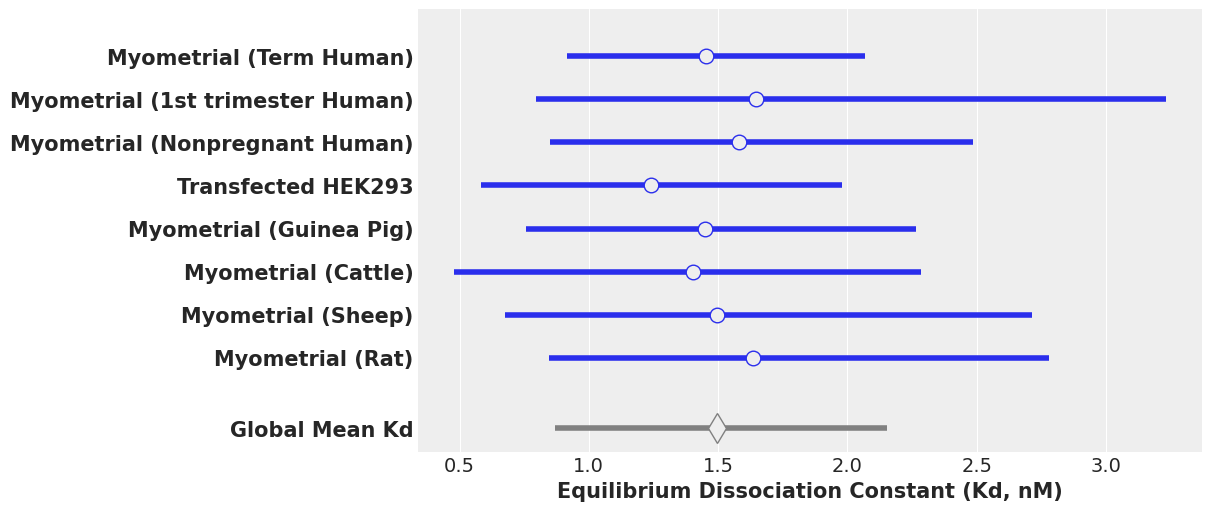

In [12]:
# Plot the result  
ax = pm.plot_forest(
    varying_intercept_trace_kd,
    var_names=["source_intercept", "mu0"],
    transform=np.exp,
    hdi_prob= 0.95,
    quartiles = False,
    figsize=(12, 5),
    combined=True,
    r_hat=False,
    labeller=az.labels.NoVarLabeller(),
    linewidth=2,
    markersize=14,
)
# Make y-axis labels bigger and bolder
for label in ax[0].get_yticklabels():
    label.set_fontsize(15)  # Change the number to the size you want
    label.set_weight('bold')  # Change 'bold' to 'normal' to make the labels not bold
#ax[0].set_ylabel("Cell assayed", weight='bold')
ax[0].set_xlabel('Equilibrium Dissociation Constant (Kd, nM)', weight='bold')
#ax[0].set_title('95% Highest Density Interval', weight='bold')
ax[0].set_title('')
# change labels
labels = [
    'Myometrial (Term Human)',
    'Myometrial (1st trimester Human)',
    'Myometrial (Nonpregnant Human)',
    'Transfected HEK293',
    'Myometrial (Guinea Pig)',
    'Myometrial (Cattle)',
    'Myometrial (Sheep)',
    'Myometrial (Rat)',
    'Global Mean Kd'
]
# Reverse the order of the list
labels.reverse()
# Change the y-axis labels
ax[0].set_yticklabels(labels)  
# Change the color of the first HDI
ax[0].get_children()[0].set_edgecolor('gray')
# Change the color of the marker
ax[0].get_children()[1].set_color('gray')
# Change the type of the marker
ax[0].get_children()[1].set_marker('d')
# Change the size of the marker
ax[0].get_children()[1].set_markersize(15)
# Save the figure
plt.savefig("Equilibrium_Dissociation_Constant_All_cells.png")
output = varying_intercept_trace_kd
# Create a table of the results
Result =  create_table(output, var_name=["source_intercept"], mean = ["mu0"], hdi_interval=0.95, round_to=4)
display(Result)
# Save the table
Result.to_excel('Equilibrium_Dissociation_Constant_All_cells.xlsx')

## Human

#### Data set up

In [13]:
# Human Data likelihood or Outcome
log_kd_Human_m = log_kd[:-9]
display(log_kd_Human_m)
# Mean human binding affinity
mean_human_binding_affinity = np.exp(log_kd_Human_m.mean())
# Creating data human dataframe
oxtr_data_kd_human_m = oxtr_data_kd[:-9]
# Sources
sources_human, source_lookup_human, source_human = create_lookup(oxtr_data_kd_human_m, 'Source')
# Methods
methods_human, method_lookup_human, method_human = create_lookup(oxtr_data_kd_human_m, 'Method')


array([ 0.62593843, -0.07257069,  0.18232156,  0.47000363,  0.53062825,
        0.99694863,  1.2029723 , -0.04082199])

#### Model

In [14]:
# Centered Parameterization
coords = {"Methods": ["0", "1", "2", "3", "4"], "obs_id": np.arange(method_human.size)}
coords["Source"] = sources_human

with pm.Model(coords=coords) as varying_intercept:
    method_idx = pm.MutableData("method_idx", method_human, dims="obs_id")
    source_idx = pm.MutableData("source_idx", source_human, dims="obs_id")
    
    # HyperPriors
    mu0 = pm.Normal("mu0", mu=log_kd_mean, sigma=1) 
    sigma0 = pm.HalfCauchy("sigma0", 1.0) 

    # Varying intercepts
    source_intercept = pm.Normal("source_intercept", mu=mu0, sigma=sigma0, dims="Source")

    # Common slope
    beta = pm.Normal("beta", mu=0, sigma=1) # consider adding two slopes for beta arrestin one and two
    
    # Expected value per receptor
    theta = source_intercept[source_idx] + beta * method_idx

    # Model error
    sigma = pm.HalfCauchy("sigma", 1.0) # HalfCauchy/Exponential is a distribution over positive values

    # Data likelihood or Outcome
    y = pm.Normal("y", mu=theta, sigma=sigma, observed=log_kd_Human_m, dims="obs_id")

In [15]:
# Bayesian model run
with varying_intercept:
    varying_intercept_trace_hm = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, sigma0, source_intercept, beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.


#### Results

mean  \
source_intercept[Myometrial (Term Human)]           1.5144   
source_intercept[Myometrial (1st trimester Human)]  2.0897   
source_intercept[Myometrial (Nonpregnant Human)]    1.7594   
Global Mean                                         1.8004   

                                                    Standard deviation  \
source_intercept[Myometrial (Term Human)]                       0.4108   
source_intercept[Myometrial (1st trimester Human)]              1.0496   
source_intercept[Myometrial (Nonpregnant Human)]                0.6394   
Global Mean                                                     0.8035   

                                                    HDI(2.5%) Minimum  \
source_intercept[Myometrial (Term Human)]                      0.9033   
source_intercept[Myometrial (1st trimester Human)]             0.7849   
source_intercept[Myometrial (Nonpregnant Human)]               0.8658   
Global Mean                                                    0.6633   

                                                    HDI(97.5%) Maximum  \
source_intercept[Myometrial (Term Human)]                       2.2841   
source_intercept[Myometrial (1st trimester Human)]              4.4092   
source_intercept[Myometrial (Nonpregnant Human)]                3.0183   
Global Mean                                                     3.4328   

                                                    Quartile Minumum  \
source_intercept[Myometrial (Term Human)]                     1.3087   
source_intercept[Myometrial (1st trimester Human)]            1.5841   
source_intercept[Myometrial (Nonpregnant Human)]              1.4483   
Global Mean                                                   1.4445   

                                                    Quartile Maximum  
source_intercept[Myometrial (Term Human)]                     1.7512  
source_intercept[Myometrial (1st trimester Human)]            2.6501  
source_intercept[Myometrial (Nonpregnant Human)]              2.1344  
Global Mean                                                   2.1982

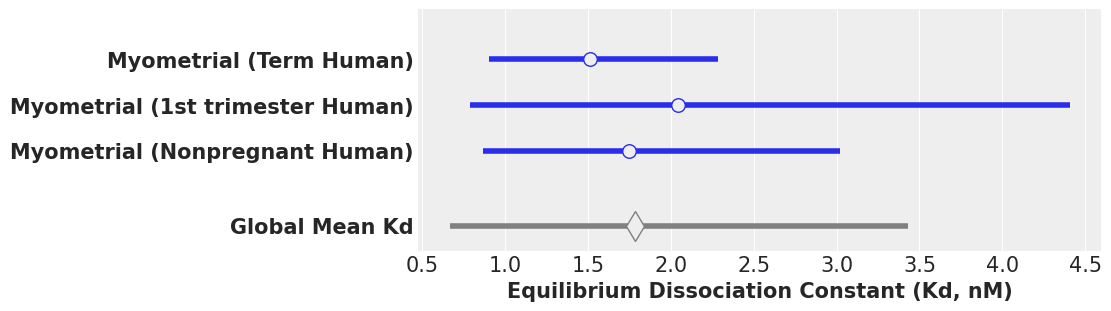

In [17]:
# Plot the result
ax = pm.plot_forest(
    varying_intercept_trace_hm,
    var_names=["source_intercept", "mu0"],
    textsize=15,
    transform=np.exp,
    hdi_prob= 0.95,
    quartiles = False, # This removes the quartiles
    figsize=(11, 3),
    combined=True,
    r_hat=False,
    labeller=az.labels.NoVarLabeller(),
    linewidth=2,
    markersize=13, 
)
#ax[0].set_ylabel("Cell assayed", weight='bold')
ax[0].set_xlabel('Equilibrium Dissociation Constant (Kd, nM)', weight='bold')
#ax[0].set_title('95% Highest Density Interval', weight='bold')
ax[0].set_title('')
ax[0].set_yticklabels(['Global Mean Kd', 'Myometrial (Nonpregnant Human)', 'Myometrial (1st trimester Human)', 'Myometrial (Term Human)'], weight='bold')
# Change the color of the first HDI
ax[0].get_children()[0].set_edgecolor('gray')
# Change the color of the marker
ax[0].get_children()[1].set_color('gray')
# Change the type of the marker
ax[0].get_children()[1].set_marker('d')
# Change the size of the marker
ax[0].get_children()[1].set_markersize(15)
# Save the plot
plt.savefig("Equilibrium_Dissociation_Constant_Human_Myometrial_cells.png")
output = varying_intercept_trace_hm
# Create a table of the results
Result =  create_table(output, var_name=["source_intercept"], mean = ["mu0"], hdi_interval=0.95, round_to=4)
display(Result)
Result.to_excel('Equilibrium_Dissociation_Constant_Human_Myometrial_cells.xlsx')